# Prerequisites

## Coding Styles for Python

* [PEP 8 -- Style Guide for Python Code](https://www.python.org/dev/peps/pep-0008/)
* [python style guide in google](https://google.github.io/styleguide/pyguide.html)
* [파이썬 docstring 스타일 가이드에 대한 정리](https://medium.com/@kkweon/%ED%8C%8C%EC%9D%B4%EC%8D%AC-doc-%EC%8A%A4%ED%83%80%EC%9D%BC-%EA%B0%80%EC%9D%B4%EB%93%9C%EC%97%90-%EB%8C%80%ED%95%9C-%EC%A0%95%EB%A6%AC-b6d27cd0a27c)

----

```python
  def connect_to_next_port(self, minimum: int) -> int:
    """Connects to the next available port.

    Args:
      minimum: A port value greater or equal to 1024.

    Returns:
      The new minimum port.

    Raises:
      ConnectionError: If no available port is found.
    """
    if minimum < 1024:
      # Note that this raising of ValueError is not mentioned in the doc
      # string's "Raises:" section because it is not appropriate to
      # guarantee this specific behavioral reaction to API misuse.
      raise ValueError(f'Min. port must be at least 1024, not {minimum}.')
    port = self._find_next_open_port(minimum)
    if not port:
      raise ConnectionError(
          f'Could not connect to service on port {minimum} or higher.')
    assert port >= minimum, (
        f'Unexpected port {port} when minimum was {minimum}.')
    return port
```

----


## References:

* [How to get model info in caffe and pytorch](http://echo.etri.re.kr:8090/display/~kimkk/how+to+get+model+info+in+caffe+and+pytorch)

# Import related modules

## numpy modules

In [1]:
import numpy as np
import math

## pycaffe modules

In [2]:
import caffe
from caffe import layers as L, params as P

## PIL modules

In [3]:
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
%matplotlib inline

----

# Input Image Trasform Functions

관련 confluence페이지 
* [Input Image Transform and to_image_list()](http://echo.etri.re.kr:8090/pages/viewpage.action?pageId=78088792)

입력으로 주어지는 이미지는 PIL.Image 클래스를 사용하여 RGB모드로 오픈하며, 다음과 같은 3가지 transform을 거친다.
이 과정은 maskrcnn_benchmark/data/transforms/transforms.py에서 구현한다. 


* Resize

> 주어진 입력 이미지를 detection 모델의 입력으로 사용할 수 있도록, aspect ratio를 보존하면서 resize한다.
> resize할 크기는 get_size()함수로 결정한다. 기본적인 알고리즘은
>  * w, h 중 작은 값을 480으로 aspect ratio를 유지하면서 w' h'으로 resize한 후,
>  * w', h'중 큰 값이 640보다 크다면 640으로 aspect resize
>
> resize된 크기는 다시 to_image_list에서 W, H가 32의 배수가 되도록 모자라는 부분을 zero pixel로 패딩해준후 모델의 입력으로 >사용한다.

* ToTensor

> Normalize 처리를 위하여 이미지를 PIL.Image 타입에서 tensor (ndarray)로 변환하고, 픽셀값을 255로 나눠준다.

* Normalize

> tensor에 대하여 Channel Order를 RGB에서 BGR로 변경하고 픽셀값에 255를 곱해준다.
> 각 픽셀에 대하여 mean을 빼주고, std로 나누어 주는 normalization을 수행한다.
> * mean은 cfg.INPUT.PIXEL_MEAN: [102.9801, 115.9465, 122.7717]으로 지정된 고정값
> * std는 cfg.INPUT.PIXEL_STD: [1.0, 1.0, 1.0]으로 지정된 고정값

**Questions**
* 애초에 BRG로 오픈하면 되지 않을까?
* ToTensor에서 255로 나눠주고, Normalize에서 다시 255를 곱해주나?

----

## Resize


### get_size()

먼저 Resize할 크기를 결정하는 함수는 다음과 같다.

In [4]:
def get_size(pil_image, mode='keep_ratio'):
    # mask rcnn transforms.py get_size() replica
    """Return suitable size for detection or recognition model

    Args:
        pil_image (PIL.Image) : PIL image opened with RGB mode (512x438=WxH)
        mode (str) : resize mode
            "horizontal_padding" | 'keep_ratio'

    Returns:
        (int, int) : tuple of (width, height) for resizing
    """
    # get size of pil_image
    w, h =  pil_image.size
    
    # output image width and height initialize
    ow, oh = -1, -1

    # i) recognition model: 'horizontal_padding'
    if (mode=='horizontal_padding'):
        ow, oh = -1, -1
        target_width = int(w * (oh/h))
        if target_width < oh:
            target_width = oh

        if target_width > ow:
            target_width = ow

        ow = target_width

    # ii) detection model: 'keep_ratio'
    elif (mode == 'keep_ratio'):
        min_size = 480
        max_size = 640
        min_original_size = float(min((w,h)))
        max_original_size = float(max((w,h)))

        # summary
        # take smaller one from height or width, and resize smaller one to 480
        # and larger one is resized while keeping ratio

        # i) first determine max_size
        #   max_size : min_size  = max_original_size : min_original_size  -- (1)
        #       ? :  480  =  512 : 438
        # from (1) max_size = max_original_size * min_size / min_orignal_size
        #                   =  480*512/438 = 531.09 = 561
        # max size= 561.095
        calc_max_size = max_original_size / min_original_size * min_size
        max_size = min(calc_max_size, max_size)

        # ii) determine min_size from the determined max_size
        #   max_size : min_size  = max_original_size : min_original_size  -- (2)
        #      561.095  :  ?  =  512 : 438
        # from (2) min_size  =  max_size * min_original_size /  max_original_size
        #                    = 561.095 * 438 /512 = 479.99 = round(479.99) = 480
        min_size = round(max_size * min_original_size / max_original_size)

        # if input image is a vertical image, i.e, height > width
        #   ow = min_size, oh = max_size
        # if input image is a horizontal image, i.e, width > height
        #   ow = max_size, oh = min_size
        ow = min_size if w < h else max_size

        oh = max_size if w < h else min_size

        # oh : 480, ow = 561.095
        # int() cause round off
        # oh : 480, ow = 561,
        # (438, 512)  => (480, 561)   ; keep ratio = 1.168

    # return target size with WXH format
    return (int(ow), int(oh))


### pil_image_resize()

resize할 크기를 결정하고 나면, 실제로 다음과 같은 함수를 통하여 PIL image를 resize한다.

In [5]:
def pil_image_resize(pil_image):
    """Returns resized the PIL image using BILINEAR interpolation

    Args:
        pil_image (PIL.Image) : original PIL image to be resized
            ex. 512x438 => 561 x 480

    Returns:
        PIL.Image : resized PIL Image
    """
    # cacl height and width after resize
    #size = get_size(pil_image, mode='keep_ratio')
    width, height = get_size(pil_image, mode='keep_ratio')
    
    # do resize with BILINEAR interpolaton
    #resized_pil_image = Image.resize(size, resample=Image.BILINEAR)
    resized_pil_image =pil_image.resize((width,height), resample=Image.BILINEAR)

    # WxH = 512x438 RGB ==> WxH = 561x480 RGB
    return resized_pil_image


## PIL image to numpy.ndarray conversion

### to_ndarray()

In [6]:
def to_ndarray(pil_image):
    """Returns numpy.ndarray converted from PIL image of RGB mode

    Args:
    pil_image (PIL.Image):  resized PIL image, 561x480 (WxH), mode=RGB

    Returns:
        ndarray of float32 : array with shape of CxHxW with pixel value range 0.0 ~ 1.0
    """
    # read PIL image into np.ndarray
    image_array = np.array(pil_image)

    # pil_image.size : (w, h)
    # pil_image.mode : "RGB", len(pil_image.mode) =3
    w, h = pil_image.size
    c = len(pil_image.mode)

    # reshape 707840 into HWC (480, 561, 3) format
    image_array = image_array.reshape(h, w, c)

    # change dimension order from HWC to CHW format
    image_array = image_array.transpose(2, 0, 1)

    # change pixel value range 0 - 255 to 0.0 ~ 1.0
    image_array = np.float32(image_array) / 255.0
    
    return image_array


## Normalize

numpy.ndarray에 대하여 Channel Order를 RGB에서 BGR로 변경하고 픽셀값에 255를 곱해준다.
각 픽셀에 대하여 mean을 빼주고, std로 나누어 주는 normalization을 수행한다.

Note that
PIL uses RGB ch. order while OpenCV BGR ch. order
* [https://note.nkmk.me/en/python-opencv-bgr-rgb-cvtcolor/](https://note.nkmk.me/en/python-opencv-bgr-rgb-cvtcolor/)

Normalization에 사용하는 mean과 std의 값은 configuration에서 고정된 값을 사용한다.
- mean은 cfg.INPUT.PIXEL_MEAN: [102.9801, 115.9465, 122.7717]으로 지정된 고정값
-  std는 cfg.INPUT.PIXEL_STD: [1.0, 1.0, 1.0]으로 지정된 고정값


### normalize()

**To Do**
>  <span style="color:purple">Inference시에 training 이미지의 channel별 mean을 빼기보다, testing 이미지의 channel 별로 mean을 구해서 빼주는게 맞지 않을까 싶다.</span>


In [7]:
def normalize(image_array):
    """ Returns normalized ndarray of BGR ch. order
        with configuration defined mean and std

    Args:
        image_array (np.ndarray) : array format of resized input image, RGB mode and CHW dimension order

    Returns:
       ndarray: normalized with configuration defined mean and std
           dimension order: CHW, channel order: BGR
    """
    mean = [102.9801, 115.9465, 122.7717]
    std =  [1.0, 1.0, 1.0]

    # change ch. order from RGB to BGR
    # https://note.nkmk.me/en/python-opencv-bgr-rgb-cvtcolor/
    image_array = image_array[[2,1,0], :, :]

    # multiply 255 to each pixel value
    image_array = image_array*255

    # normalize with mean and std
    # since std is [1.0, 1.0, 1.0], just subtract mean
    # note that CHW shape with channel order BGR
    image_array[0, :, :] = image_array[0, :, :] - mean[0]
    image_array[1, :, :] = image_array[1, :, :] - mean[1]
    image_array[2, :, :] = image_array[2, :, :] - mean[2]
    

    return image_array


----

## Zero padding for 32 divisiblity

Transform을 통하여 ndarray로 변환된 이미지 데이타(```image_array````)는 최종적으로 height $H$와 width $W$가 32의 배수가 되도록 해주어야 하는데, 이때는 resize를 하지 않고, 추가된 영역을 zero image로 패딩해준다.

* 이미지 데이타의 크기에서 32의 배수가 되는 height $H'$와 width $W'$을 다음과 같이 계산하고
  * $H' = \lceil H/32 \rceil \times 32 $
  * $W' = \lceil W/32 \rceil \times 32 $
* $3 \times H'  \times W'$의 zero image (```padded_image_array```)를 생성하고,
* ```padded_image_array```의 ```[0:3, 0:H, 0:W]``` 영역위로  $3 \times H \times W$ ```image_array```의 값으로 덮어쓴다.

### zero_padding()

In [8]:
def zero_padding(image_array, size_divisible = 32):
    """Returns batched padded array with new width/height with 32 divisible and pad with zero pixels

    Args:
        image_array (np.ndarray) : image array of CHW dimension order and RGB channel order
            ndarray of shape format (3, H, W), RGB channel order
        size_divisible (int, default:32) : which multiple of width and height

    Returns:
        ndarray of shape [1, 3, H', W']:
            batched image array of shape (1, 3, H', W'), H' and W' is multiple of 32
            increase region filled with zeros and batch dimension added at axis 0
    """
    # calc size divisible new height and width
    c, h, w = image_array.shape
        
    new_h = int(np.ceil(h / size_divisible )* size_divisible)
    new_w = int(np.ceil(w / size_divisible )* size_divisible)

          
    # create black image with size divisible
    padded_image_array = np.zeros((3, new_h, new_w), dtype= np.float32)

    # overlay image_array on padded_image
    padded_image_array[:c, :h, :w] = image_array
    
    # add batch dimension into image_array
    # (3, H, W) => (1, 3, H, W)    
    padded_image_array = np.expand_dims(padded_image_array, axis=0)
    
    return padded_image_array

----

## 동작 일치성 테스트

### input image

In [9]:
image_file_path = "./sample_images/detection/1594202471809.jpg"
pil_image = Image.open(image_file_path).convert('RGB')

In [10]:
pil_image.size

(512, 438)

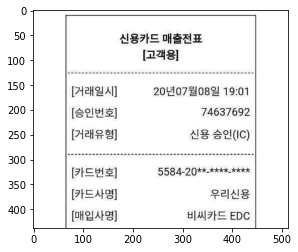

In [11]:
plt.imshow(pil_image)

In [12]:
# PIL image resize
resized_pil_image=pil_image_resize(pil_image)

In [13]:
resized_pil_image.size

(561, 480)

### resized image

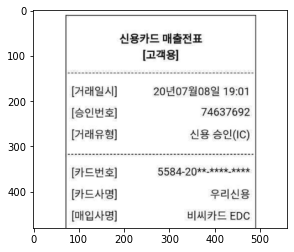

In [14]:
plt.imshow(resized_pil_image)

In [15]:
# PIL image to np.ndarray
image_array = to_ndarray(resized_pil_image)

In [16]:
image_array.shape

(3, 480, 561)

### ndarrayed image check

In [17]:
image_array

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)

ndarray tmp_img.shape (H, W, C): (480, 561, 3)
PIL tmp_img.size (W, H): (561, 480)


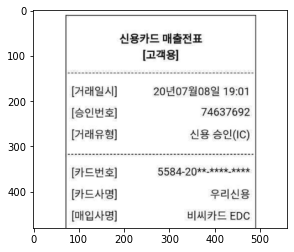

In [41]:
# Make deep copy
tmp_img = image_array.copy()

# pixel value range 0.0~1.0 to 0.0~255.0
tmp_img *=  255


# change dimension order from CHW to HWC for dispaly
tmp_img = tmp_img.transpose(1, 2, 0)

# chnage float32 to uint8
tmp_img = tmp_img.astype(np.uint8)
print(f"ndarray tmp_img.shape (H, W, C): {tmp_img.shape}")

# conver image array to PIL.Image
tmp_img = Image.fromarray(tmp_img, 'RGB')

print(f"PIL tmp_img.size (W, H): {tmp_img.size}")
plt.imshow(tmp_img)

### normalized image

In [19]:
# normalize with mean and std
# mean and std is defined in configuration
normalized_image_array = normalize(image_array)

tmp_img_array.shape (H, W, C): (480, 561, 3)
tmp_img.size (W, H): (561, 480)


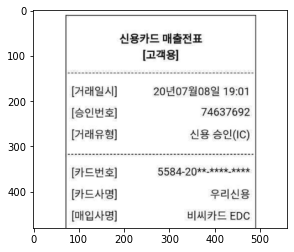

In [36]:
# shape CxHxW, ch. order BGR, pixel value range: -122.77 ~ 152.01
# normalized with mean and std
mean = [102.9801, 115.9465, 122.7717]
std =  [1.0, 1.0, 1.0]

# Make deep copy !!
tmp_img = normalized_image_array.copy()

# unnormalized to 0. ~ 255.0
tmp_img[0, :, :] = tmp_img[0, :, :] + mean[0]
tmp_img[1, :, :] = tmp_img[1, :, :] + mean[1]
tmp_img[2, :, :] = tmp_img[2, :, :] + mean[2]

# change ch. order from BGR to RGB
# https://note.nkmk.me/en/python-opencv-bgr-rgb-cvtcolor/
tmp_img = tmp_img[[2,1,0], :, :]

# change dimension order from CHW to HWC for dispaly
tmp_img = tmp_img.transpose(1, 2, 0)

# flaot 0.0~255.0 to 0 ~ 255
tmp_img_array = tmp_img.astype(np.uint8)

print(f"tmp_img_array.shape (H, W, C): {tmp_img_array.shape}")

# conver image array to PIL.Image
tmp_img = Image.fromarray(tmp_img_array, 'RGB')
print(f"tmp_img.size (W, H): {tmp_img.size}")
plt.imshow(tmp_img)

### zero padded image

In [21]:
batch_image_array = zero_padding(normalized_image_array, size_divisible = 32)


zero_padded.size: (576, 480)


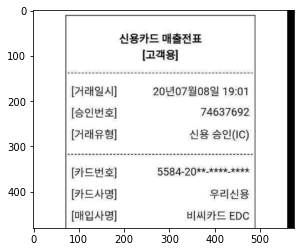

In [34]:
size_divisible = 32

h, w, c = tmp_img_array.shape
     
new_h = int(np.ceil(h / size_divisible )* size_divisible)
new_w = int(np.ceil(w / size_divisible )* size_divisible)

# create black image with size divisible
zero_padded = np.zeros((new_h, new_w, c), dtype= np.uint8)

# overlay image_array on padded_image
zero_padded[:h, :w, :c] = tmp_img_array

# conver image array to PIL.Image
zero_padded = Image.fromarray(zero_padded, 'RGB')
print(f"zero_padded.size: {zero_padded.size}")
plt.imshow(zero_padded)

----

###  Transform 동작 일치성 확인
* [numpy.array_equal](https://numpy.org/doc/stable/reference/generated/numpy.array_equal.html)
* [numpy.array_equiv](https://numpy.org/doc/stable/reference/generated/numpy.array_equiv.html)
* [numpy.allclose](https://numpy.org/doc/stable/reference/generated/numpy.allclose.html)

check with Pytorch code `detection_model_debug.py` saved `./npy_save/transformed_tensor.npy` and current `normalized_image_array` variable
```python 
image_tensor = self.transforms(image)

import numpy as np
np.save("./npy_save/transformed_tensor.npy", image_tensor)
```


In [23]:
transformed_tensor = np.load("./npy_save/transformed_tensor.npy")


In [24]:
print(transformed_tensor.shape, transformed_tensor.dtype)


(3, 480, 561) float32


In [25]:
print(normalized_image_array.shape, normalized_image_array.dtype)

(3, 480, 561) float32


In [26]:
np.allclose(transformed_tensor, normalized_image_array)

True

In [27]:
np.array_equal(transformed_tensor, normalized_image_array)

True

In [28]:
np.array_equiv(transformed_tensor, normalized_image_array)

True

----

### Padded Image 일치성 확인
* [numpy.array_equal](https://numpy.org/doc/stable/reference/generated/numpy.array_equal.html)
* [numpy.array_equiv](https://numpy.org/doc/stable/reference/generated/numpy.array_equiv.html)
* [numpy.allclose](https://numpy.org/doc/stable/reference/generated/numpy.allclose.html)

check with Pytorch code `detection_model_debug.py` saved `./npy_save/padded_tensor.npy` and current `batch_image_array` variable
```python 
image_list = to_image_list(image_tensor, self.cfg.DATALOADER.SIZE_DIVISIBILITY).to(self.device)
np.save("./npy_save/padded_tensor.npy", image_list.tensors.cpu())
```



In [29]:
batch_image_array = zero_padding(normalized_image_array, size_divisible = 32)

In [30]:
batch_image_array.shape

(1, 3, 480, 576)

In [31]:
padded_tensor = np.load("./npy_save/padded_tensor.npy")

In [32]:
padded_tensor.shape

(1, 3, 480, 576)

In [33]:
np.array_equal(padded_tensor, batch_image_array)

True

---
# Caffe Model Functions

Detection model은 다음과 같은 구성요소로 이루어져 있다.
* model.backbone
  * model.backbone.body : ResNet50 (5 stages)
  * model.fpn : feature pyramid network
* model.rpn : region proposal net

전체적인 구조는 [http://echo.etri.re.kr:8090/display/~kimkk/detection+model+v2+structure](http://echo.etri.re.kr:8090/display/~kimkk/detection+model+v2+structure)를 참고한다.


----
```java
(base) kimkk@alpha ~/lomin $ vi detection_model_v2_structure_with_comments.txt

// ------------------------------------------------------------------------------------------------------------------------
// Note
// This is just structure of detection model v2, its structure does not imply any order of layers.
// In this structure analysis, some layers those not include learnable parameters, such as ReLU or maxpool are hidden.
// ------------------------------------------------------------------------------------------------------------------------

(lomin) kimkk@alpha ~/lomin $ vi model_structure.txt

GenerallizedRCNN    "model"
  │
  ├─── backbone     "model.backbone"
  │     │
  │     ├─── body  "model.backbone.body"
  │     │     ├── stem   "model.backbone.body.stem"
  │     │     │    │   related source: maskrcnn_benchmark/modelling/backbone/resenet.py StemWithFixedBatchNorm class
  │     │     │    │   --> conv1 ->  bn1 (FronzenBatchNorm2d : bn -> scale ) -> relu -> max_pool2d
  │     │     │    │
  │     │     │    ├── conv1  "model.backbone.body.stem.conv1",  // def: Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)]
  │     │     │    └── bn1    "model.backbone.body.stem.bn1",    // def: FrozenBatchNorm2d() : bn -> scale
  │     │     │
  │     │     ├── layer1 "model.backbone.body.layer1"
  │     │     │    │
  │     │     │    │    related source: maskrcnn_benchmark/modelling/backbone/resenet.py BottleneckWithFixedBatchNorm class
  │     │     │    │        + ---------------------------------------> downnsample -----------------+
  │     │     │    │        ^                                                                       |
  │     │     │    │        │                                                                       V
  │     │     │    │    --> + -> conv1 -> bn1 -> relu -> conv2 -> bn2 -> relue -> conv3 -> bn3 ->  Add  -> relu
  │     │     │    │
  │     │     │    ├─── 0   "model.backbone.body.layer1.0"
  │     │     │    │    ├── downsample "model.backbone.body.layer1.0.downsample"
  │     │     │    │    │    │
  │     │     │    │    │    ├── 0     "model.backbone.body.layer1.0.downsample.0",   // def: Conv2d(in_channels=64, out_channels=256, kernel_size=(1, 1), stride=(1, 1), bias=False) x
  │     │     │    │    │    └── 1     "model.backbone.body.layer1.0.downsample.1",   // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv1      "model.backbone.body.layer1.0.conv1",          // def: Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    ├── bn1        "model.backbone.body.layer1.0.bn1",            // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv2      "model.backbone.body.layer1.0.conv2",          // def: Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │     │    │    ├── bn2        "model.backbone.body.layer1.0.bn2",            // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv3      "model.backbone.body.layer1.0.conv3",          // def: Conv2d(in_channels=64, out_channels=256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    └── bn3        "model.backbone.body.layer1.0.bn3",            // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │
  │     │     │    │    --> conv1 -> bn1 -> relu -> conv2 -> bn2 -> relue -> conv3 -> bn3 -> relu
  │     │     │    │
  │     │     │    ├─── 1   "model.backbone.body.layer1.1"
  │     │     │    │    ├── conv1      "model.backbone.body.layer1.1.conv1",          // def: Conv2d(in_channels=256, out_channels=64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    ├── bn1        "model.backbone.body.layer1.1.bn1",            // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv2      "model.backbone.body.layer1.1.conv2",          // def: Conv2d(in_channels=64,  out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │     │    │    ├── bn2        "model.backbone.body.layer1.1.bn1",            // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv3      "model.backbone.body.layer1.1.conv3",          // def: Conv2d(in_channels=64,  out_channels=256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    └── bn3        "model.backbone.body.layer1.1.bn3",            // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │
  │     │     │    │    --> conv1 -> bn1 -> relu -> conv2 -> bn2 -> relue -> conv3 -> bn3 -> relu
  │     │     │    │
  │     │     │    └─── 2   "model.backbone.body.layer1.2"
  │     │     │         ├── conv1      "model.backbone.body.layer1.2.conv1",          // def: Conv2d(in_channels=256, out_channels=64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │         ├── bn1        "model.backbone.body.layer1.2.bn1",            // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │         ├── conv2      "model.backbone.body.layer1.2.conv2",          // def: Conv2d(in_channels=64,  out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │     │         ├── bn2        "model.backbone.body.layer1.2.bn2",            // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │         ├── conv3      "model.backbone.body.layer1.2.conv3",          // def: Conv2d(in_channels=64,  out_channels=256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │         └── bn3        "model.backbone.body.layer1.2.conv2",          // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │
  │     │     ├── layer2 "model.backbone.body.layer2"
  │     │     │    │
  │     │     │    ├─── 0   "model.backbone.body.layer2.0"
  │     │     │    │    ├── downsample  "model.backbone.body.layer2.0.downsample"
  │     │     │    │    │    │
  │     │     │    │    │    ├── 0      "model.backbone.body.layer2.0.downsample.0" , // def: Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), stride=(2, 2), bias=False)
  │     │     │    │    │    └── 1      "model.backbone.body.layer2.0.downsample.1",  // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv1       "model.backbone.body.layer2.0.conv1",         // def: Conv2d(in_channels=256, out_channels=128, kernel_size=(1, 1), stride=(2, 2), bias=False)
  │     │     │    │    ├── bn1         "model.backbone.body.layer2.0.bn1",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv2       "model.backbone.body.layer2.0.conv2",         // def: Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │     │    │    ├── bn2         "model.backbone.body.layer2.0.bn2",,          // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv3       "model.backbone.body.layer2.0.conv3",         // def: Conv2d(in_channels=128, out_channels=512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    └── bn3         "model.backbone.body.layer2.0.bn3",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │
  │     │     │    ├─── 1   "model.backbone.body.layer2.1"
  │     │     │    │    ├── conv1       "model.backbone.body.layer2.1.conv1",         // def: Conv2d(in_channels=512, out_channels=128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    ├── bn1         "model.backbone.body.layer2.1.bn1",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv2       "model.backbone.body.layer2.1.conv2",         // def: Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │     │    │    ├── bn2         "model.backbone.body.layer2.1.bn2",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv3       "model.backbone.body.layer2.1.conv3",         // def: Conv2d(in_channels=128, out_channels=512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    └── bn3         "model.backbone.body.layer2.1.bn3",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │
  │     │     │    ├─── 2   "model.backbone.body.layer2.2"
  │     │     │    │    ├── conv1       "model.backbone.body.layer2.2.conv1",         // def: Conv2d(in_channels=512, out_channels=128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    ├── bn1         "model.backbone.body.layer2.2.bn1",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv2       "model.backbone.body.layer2.2.conv2",         // def: Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │     │    │    ├── bn2         "model.backbone.body.layer2.2.bn2",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv3       "model.backbone.body.layer2.2.conv3",         // def: Conv2d(in_channels=128, out_channels=512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    └── bn3         "model.backbone.body.layer2.2.bn3",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │
  │     │     │    └─── 3 "model.backbone.body.layer2.3"
  │     │     │         ├── conv1       "model.backbone.body.layer2.3.conv1",         // def: Conv2d(in_channels=512, out_channels=128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │         ├── bn1         "model.backbone.body.layer2.3.bn1",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │         ├── conv2       "model.backbone.body.layer2.3.conv2",         // def: Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │     │         ├── bn2         "model.backbone.body.layer2.3.bn2",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │         ├── conv3       "model.backbone.body.layer2.3.conv3",         // def: Conv2d(in_channels=128, out_channels=512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │         └── bn3         "model.backbone.body.layer2.3.bn3",           // def: FrozenBatchNorm2d() : bn -> scale -> relu "==> C2, Input to FPN"
  │     │     │
  │     │     ├── layer3 "model.backbone.body.layer3"
  │     │     │    │
  │     │     │    ├─── 0 "model.backbone.body.layer3.0"
  │     │     │    │    ├── downsample "model.backbone.body.layer3.0.downsamples"
  │     │     │    │    │    │
  │     │     │    │    │    ├── 0      "model.backbone.body.layer3.0.downsamples.0", // def: Conv2d(in_channels=512, out_channels=1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
  │     │     │    │    │    └── 1      "model.backbone.body.layer3.0.downsamples.0", // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv1       "model.backbone.body.layer3.0.conv1",         // def: Conv2d(in_channels=512, out_channels=256, kernel_size=(1, 1), stride=(2, 2), bias=False)
  │     │     │    │    ├── bn1         "model.backbone.body.layer3.0.bn1",           // def: # FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv2       "model.backbone.body.layer3.0.conv2",         // def: Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │     │    │    ├── bn2         "model.backbone.body.layer3.0.bn2",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv3       "model.backbone.body.layer3.0.conv3",         // def: Conv2d(in_channels=256, out_channels=1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    └── bn3         "model.backbone.body.layer3.0.bn3",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │
  │     │     │    ├─── 1 "model.backbone.body.layer3.1"
  │     │     │    │    ├── conv1       "model.backbone.body.layer3.1.conv1",         // def: Conv2d(in_channels=1024, out_channels=256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    ├── bn1         "model.backbone.body.layer3.1.bn1",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv2       "model.backbone.body.layer3.1.conv2",         // def: Conv2d(in_channels=256,  out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │     │    │    ├── bn2         "model.backbone.body.layer3.1.bn2",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv3       "model.backbone.body.layer3.1.conv3",         // def: Conv2d(in_channels=256,  out_channels=1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    └── bn3         "model.backbone.body.layer3.1.bn3",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │
  │     │     │    ├─── 2 "model.backbone.body.layer3.2"
  │     │     │    │    ├── conv1       "model.backbone.body.layer3.2.conv1",         // def: Conv2d(in_channels=1024, out_channels=256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    ├── bn1         "model.backbone.body.layer3.2.bn1",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv2       "model.backbone.body.layer3.2.conv2",         // def: Conv2d(in_channels=256,  out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │     │    │    ├── bn2         "model.backbone.body.layer3.2.bn2",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv3       "model.backbone.body.layer3.2.conv3",         // def: Conv2d(in_channels=256,  out_channels=1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    └── bn3         "model.backbone.body.layer3.2.bn3",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │
  │     │     │    ├─── 3 "model.backbone.body.layer3.3"
  │     │     │    │    ├── conv1       "model.backbone.body.layer3.3.conv1",         // def: Conv2d(in_channels=1024, out_channels=256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    ├── bn1         "model.backbone.body.layer3.3.bn1",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv2       "model.backbone.body.layer3.3.conv2",         // def: Conv2d(in_channels=256,  out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │     │    │    ├── bn2         "model.backbone.body.layer3.3.bn2",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv3       "model.backbone.body.layer3.3.conv3",         // def: Conv2d(in_channels=256,  out_channels=1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    └── bn3         "model.backbone.body.layer3.3.bn3",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │
  │     │     │    ├─── 4 "model.backbone.body.layer3.4"
  │     │     │    │    ├── conv1       "model.backbone.body.layer3.4.conv1",         // def: Conv2d(in_channels=1024, out_channels=256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    ├── bn1         "model.backbone.body.layer3.4.bn1",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv2       "model.backbone.body.layer3.4.conv2",         // def: Conv2d(in_channels=256,  out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │     │    │    ├── bn2         "model.backbone.body.layer3.4.bn2",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │    ├── conv3       "model.backbone.body.layer3.4.conv3",         // def: Conv2d(in_channels=256,  out_channels=1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │    │    └── bn3         "model.backbone.body.layer3.4.bn3",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │    │
  │     │     │    └─── 5 "model.backbone.body.layer3.5"
  │     │     │         ├── conv1       "model.backbone.body.layer3.5.conv1",         // def: Conv2d(in_channels=1024, out_channels=256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │         ├── bn1         "model.backbone.body.layer3.5.bn1",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │         ├── conv2       "model.backbone.body.layer3.5.conv2",         // def: Conv2d(in_channels=256,  out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │     │         ├── bn2         "model.backbone.body.layer3.5.bn2",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │     │         ├── conv3       "model.backbone.body.layer3.5.conv3",         // def: Conv2d(in_channels=256,  out_channels=1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │     │         └── bn3         "model.backbone.body.layer3.5.bn3",           // def: FrozenBatchNorm2d() : bn -> scale -> relu "==> C3 : Input to FPN"
  │     │     │
  │     │     └── layer4 "model.backbone.body.layer4"
  │     │          │
  │     │          ├─── 0 "model.backbone.body.layer4.0"
  │     │          │    ├── downsample  "model.backbone.body.layer4.0.downsample"
  │     │          │    │   │
  │     │          │    │   ├── 0       "model.backbone.body.layer4.0.downsample.0",  // def: Conv2d(in_channels=1024, out_channels=2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
  │     │          │    │   └── 1       "model.backbone.body.layer4.0.downsample.1",  // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │          │    ├── conv1       "model.backbone.body.layer4.0.conv1",         // def: Conv2d(in_channels=1024, out_channels=512, kernel_size=(1, 1), stride=(2, 2), bias=False)
  │     │          │    ├── bn1         "model.backbone.body.layer4.0.bn1",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │          │    ├── conv2       "model.backbone.body.layer4.0.conv2",         // def: Conv2d(in_channels=512,  out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │          │    ├── bn2         "model.backbone.body.layer4.0.bn2",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │          │    ├── conv3       "model.backbone.body.layer4.0.conv3",         // def: Conv2d(in_channels=512,  out_channels=2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │          │    └── bn3         "model.backbone.body.layer4.0.bn3",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │          │
  │     │          ├─── 1 "model.backbone.body.layer4.1"
  │     │          │    ├── conv1       "model.backbone.body.layer4.1.conv1",         // def: Conv2d(in_channels=2048, out_channels=512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │          │    ├── bn1         "model.backbone.body.layer4.1.bn1",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │          │    ├── conv2       "model.backbone.body.layer4.1.conv2",         // def: Conv2d(in_channels=512,  out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │          │    ├── bn2         "model.backbone.body.layer4.1.bn2",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │          │    ├── conv3       "model.backbone.body.layer4.1.conv3",         // def: Conv2d(in_channels=512,  out_channels=2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │          │    └── bn3         "model.backbone.body.layer4.1.bn3",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │          │
  │     │          └─── 2 "model.backbone.body.layer4.2"
  │     │               ├── conv1       "model.backbone.body.layer4.2.conv1",         // def: Conv2d(in_channels=2048, out_channels=512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │               ├── bn1         "model.backbone.body.layer4.2.bn1",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │               ├── conv2       "model.backbone.body.layer4.2.conv2",         // def: Conv2d(in_channels=512,  out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  │     │               ├── bn2         "model.backbone.body.layer4.2.bn2",           // def: FrozenBatchNorm2d() : bn -> scale -> relu
  │     │               ├── conv3       "model.backbone.body.layer4.2.conv3",         // def: Conv2d(in_channels=512,  out_channels=2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  │     │               └── bn3         "model.backbone.body.layer4.2.bn3",           // def: FrozenBatchNorm2d() : bn -> scale -> relu "==> C4 : Input to FPN"
  │     │
  │     └─── fpn "model.backbone.fpn"
  │           ├── fpn_inner2            "model.backbone.fpn.fpn_inner2",              // def: Conv2d(in_channels=512,  out_channels=1024, kernel_size=(1, 1), stride=(1, 1))
  │           ├── fpn_layer2            "model.backbone.fpn.fpn_layer2",              // def: Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  │           │
  │           ├── fpn_inner3            "model.backbone.fpn.fpn_inner3",              // def: Conv2d(in_channels=1024, out_channels=1024, kernel_size=(1, 1), stride=(1, 1))
  │           ├── fpn_layer3            "model.backbone.fpn.fpn_layer3",              // def: Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  │           │
  │           ├── fpn_inner4            "model.backbone.fpn.fpn_inner4",              // def: Conv2d(in_channels=2048, out_channels=1024, kernel_size=(1, 1), stride=(1, 1))
  │           ├── fpn_layer4            "model.backbone.fpn.fpn_layer4",              // def: Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  │           │
  │           └── top_blocks "model.backbone.fpn.topblocks"
  │                 │
  │                 ├─── p6             "model.backbone.fpn.topblocks.p6",            // def: Conv2d(in_channels=2048, out_channels=1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  │                 └─── p7             "model.backbone.fpn.topblocks.p7",            // def: Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  │
  └─── rpn          "model.rpn"
        │
        ├─── anchor_generator "model.rpn.anchor_generator"
        │           │
        │           └─── cell_anchors   "model.rpn.anchor_generator.cell_achors",     // def: BufferList()
        │
        ├─── head  "model.rpn.head"
        │           │
        │           ├─── cls_tower      "model.rpn.head.cls_tower",
        │           │     ├─── 0        "model.rpn.head.cls_tower.0",                 // def: Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        │           │     ├─── 1        "model.rpn.head.cls_tower.1",                 // def: ReLU()
        │           │     ├─── 2        "model.rpn.head.cls_tower.2",                 // def: Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        │           │     ├─── 3        "model.rpn.head.cls_tower.3",                 // def: ReLU()
        │           │     ├─── 4        "model.rpn.head.cls_tower.4",                 // def: Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ReLU()
        │           │     ├─── 5        "model.rpn.head.cls_tower.5",                 // def: ReLU()
        │           │     ├─── 6        "model.rpn.head.cls_tower.6",                 // def: Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        │           │     └─── 7        "model.rpn.head.cls_tower.7",                 // def: ReLU()
        │           │
        │           ├─── bbox_tower     "model.rpn.head.bbox_tower"
        │           │     ├─── 0        "model.rpn.head.bbox_tower.0",                // def: Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        │           │     ├─── 1        "model.rpn.head.bbox_tower.1",                // def: ReLU()
        │           │     ├─── 2        "model.rpn.head.bbox_tower.2",                // def: Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        │           │     ├─── 3        "model.rpn.head.bbox_tower.3",                // def: ReLU()
        │           │     ├─── 4        "model.rpn.head.bbox_tower.4",                // def: Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ReLU()
        │           │     ├─── 5        "model.rpn.head.bbox_tower.5",                // def: ReLU()
        │           │     ├─── 6        "model.rpn.head.bbox_tower.6",                // def: Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        │           │     └─── 7        "model.rpn.head.bbox_tower.7",                // def: ReLU()
        │           │
        │           ├─── cls_logits     "model.rpn.head.cls_logits",                  // def: Conv2d(in_channels=1024, out_channels=9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        │           │
        │           └─── bbox_pred      "model.rpn.head.bbox_pre",                    // def: Conv2d(in_channels=1024, out_channels=36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        │
        └─── box_selector_test "model.rpn.box_selector_test",                         // def: RetinaNetPostProcessor()

```

----

## Backbone Resnet 50 Build
Original Code Source
* [https://gist.github.com/kyamagu/80c343a14ae4564ef79b53f0b01cd57e](https://gist.github.com/kyamagu/80c343a14ae4564ef79b53f0b01cd57e)
* [https://gist.github.com/rezoo/a1c8d1459b222fc5658f](https://gist.github.com/rezoo/a1c8d1459b222fc5658f)

----

### Common Conv-BN-Relu Block

mask rcnn에서 사용하는 FrozenBatchNorm2d 방식으로 구현할 것.
* [Why FrozenBatchNorm2d in ResNet?](http://echo.etri.re.kr:8090/pages/viewpage.action?pageId=78088692)
* https://github.com/facebookresearch/maskrcnn-benchmark/issues/267
* [Batch Normalization 설명 및 구현](http://echo.etri.re.kr:8090/pages/viewpage.action?pageId=78088844)

**Caffe BatchNorm vs Torch BatchNorm2d**

* [During test phase, the output of Batch Normalization layer is not equal to (input-mean)/sqrt(var + eps)?](https://github.com/BVLC/caffe/issues/4885)
> `net.params['bn_1'][0].data` : mean  
> `net.params['bn_1'][1].data` : variance   
> `net.params['bn_1'][2].data` : scores a scale factor, which I should divide from each mean and variance at this layer.    

So in Caffe, the output of BN layer calculated by: 

$
\begin{aligned}
\frac{\frac{ \text{input} - \text{mean} }{ \text{scale_factor} }}{\sqrt { \frac{ \text{var }}{ \text{scale_factor } } + \epsilon}}
\end{aligned}
$

batchnorm 없이 scale 레이어로만해도  될듯...

**Batch Norm Layer:**  
* $\gamma$ --> Var (1)   
* $\beta$  --> mean (0)   
* $mean$  --> moving average fraction (=1)   

**Scale Layer:**
* scale --> 논문에서의 $\gamma$   
* bias  --> 논문에서의 $\beta$   

----

```python
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved.
import torch
from torch import nn
 
 
class FrozenBatchNorm2d(nn.Module):
    """
    BatchNorm2d where the batch statistics and the affine parameters
    are fixed
    """
 
    def __init__(self, n):
        super(FrozenBatchNorm2d, self).__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))
 
    def forward(self, x):
        # Cast all fixed parameters to half() if necessary
        if x.dtype == torch.float16:
            self.weight = self.weight.half()
            self.bias = self.bias.half()
            self.running_mean = self.running_mean.half()
            self.running_var = self.running_var.half()
 
        scale = self.weight * self.running_var.rsqrt()
        bias = self.bias - self.running_mean * scale
        scale = scale.reshape(1, -1, 1, 1)
        bias = bias.reshape(1, -1, 1, 1)
        return x * scale + bias
```
----


#### conv_bn_scale()

Resnet Stage의 sublayer를 구성하는 다음과 같은 building block을 생성한다.
* [Conv2d()](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) +  [FrozenBatchNorm2d()](https://github.com/facebookresearch/maskrcnn-benchmark/blob/57eec25b75144d9fb1a6857f32553e1574177daf/maskrcnn_benchmark/layers/batch_norm.py#L6) + [ReLu()](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)

In [ ]:
def conv_bn_scale(bottom, nout, bias_term=False, **kwargs):
    '''
    build a Conv -> BN -> Scale block
    
        param: bottom : input to this conv/bn/scale block
        type:  bottom : 
        param: nout   : num of oputs in Convolution Layer
        type:  uint 
        param: bias_term : bias term used in Scale Layer
        type: bool : default False
        return: top of conv, bn, scale
        rtype: 
        
    '''
    conv = L.Convolution(bottom, num_output=nout, bias_term=bias_term, **kwargs)
    
    # https://github.com/facebookresearch/maskrcnn-benchmark/blob/master/maskrcnn_benchmark/layers/batch_norm.py
    bn = L.BatchNorm(conv, use_global_stats=True, in_place=True)
    scale = L.Scale(bn, bias_term=True, in_place=True)
    return conv, bn, scale

----

### Resnet Stage Buid

```conv_bn_scale()``` 함수를 사용하여 다음과 같이 Resnet의 Stage를 구성하는 sublayer들을 생성하는 ```resnet_stage_sublayer()```를 정의한다.


**Overview diagram**

```js
             +------> [ *_downsample_0 -- *_downsample_1 --- *_downsample_scale ] -----------+
             |                                                                               |
    bottom --+---------> [ *_conv1 --- *_bn1 --- *_scale1 --- *_relu1 ] ----+                |
             |                                                              |                | 
             |     +--------------------------------------------------------+                |
             |     |                                                                         |
             |     +---> [ *_conv2 --- *_bn2 --- *_scale2 --- *_relu2 ] ----+                |
             |                                                              |                | if downsample == True
             |     +--------------------------------------------------------+                | 
             |     |                                                                         V
             |     +---> [ *_conv3 --- *_bn3 --- *_scale3 -------------------------> [ *_res: Eltwise ] ----> *__res_relu :ReLu
             |                                                                                ^
             |                                                                                | 
             |                                                                                | if downsample == False
             +--------------------------------------------------------------------------------+
```

#### resnet_stage_sublayer()

Resnet caffe codefrom
* [https://gist.github.com/kyamagu/80c343a14ae4564ef79b53f0b01cd57e](https://gist.github.com/kyamagu/80c343a14ae4564ef79b53f0b01cd57e)
* [https://gist.github.com/rezoo/a1c8d1459b222fc5658f](https://gist.github.com/rezoo/a1c8d1459b222fc5658f)


In [ ]:
def resnet_stage_sublayer(layer_name, sublayer_num, n, bottom, nout, downsample_branch=False, initial_stride=2):
    '''function for building Basic Resnet Stage
       stage 0 (stem), stage 1, stage 2, stage 3 and stage 4

    Prameters:
       layer_num  : layer number as ? in "backbone_body_layer?"
       sub_num    : sublayer number as # in "backbone_body_layer?_#"
       n          : NetSpec object
       bottom     : input to this residual block
       nout       : num. of out ch.
       downsample :  inclusion of subsample at beginning of this residula block?
                     if BottleNeck architecutre used, set True (default: False)\

       initial_stride: stride used in branch2a and branc2b. note that branch3b stride is always 1.


    Overview diagram:

             +------> [ *_downsample_0 -- *_downsample_1 --- *_downsample_scale ] -----------+
             |                                                                               |
    bottom --+---------> [ *_conv1 --- *_bn1 --- *_scale1 --- *_relu1 ] ----+                |
             |                                                              |                |
             |     +--------------------------------------------------------+                |
             |     |                                                                         |
             |     +---> [ *_conv2 --- *_bn2 --- *_scale2 --- *_relu2 ] ----+                |
             |                                                              |                | if downsample == True
             |     +--------------------------------------------------------+                |
             |     |                                                                         V
             |     +---> [ *_conv3 --- *_bn3 --- *_scale3 -------------------------> [ *_res: Eltwise ] ----> *__res_relu :ReLu
             |                                                                                ^
             |                                                                                |
             |                                                                                | if downsample == False
             +--------------------------------------------------------------------------------+
    '''
    prefix = f'{layer_name}_{sublayer_num}'

    # -----------------------------------------------------------------
    # input downsampling layer at the begining of every layer[0-4]
    # ------------------------------------------------------------------
    # In pytorch model,
    # backbone.body.laye{layer_num}.{sublayer_num}.downsample_0
    # backbone.body.layer{layer_num}.{sublayer_num}.downsample_1
    # ------------------------------------------------------------------
    if downsample_branch:
        # downsample at first layer in resnet block
        downsample_conv = f'{prefix}_downsample_0'
        downsample_bn = f'{prefix}_downsample_1'
        downsample_scale = f'{prefix}_downsample_scale'
        n[downsample_conv], n[downsample_bn], n[downsample_scale] = \
            conv_bn_scale( bottom, 4*nout, kernel_size=1, stride=initial_stride, pad=0)
    else:
        initial_stride = 1

    # ------------------------------------------------------------------
    # In pytorch model,
    # backbone.body.layer{layer_num}.{sublayer_num}.conv1
    # backbone.body.layer{layer_num}.{sublayer_num}.bn1
    # backbone.body.layer{layer_num}.{sublayer_num}.scale1
    # backbone.body.layer{layer_num}.{sublayer_num}.relu1
    # ------------------------------------------------------------------
    conv1 = f'{prefix}_conv1'
    bn1 = f'{prefix}_bn1'
    scale1 = f'{prefix}_scale1'

    n[conv1], n[bn1], n[scale1] = \
        conv_bn_scale( bottom, nout, kernel_size=1, stride=initial_stride, pad=0)

    relu1 = f'{prefix}_relu1'
    n[relu1] = L.ReLU(n[scale1], in_place=True)

    # ------------------------------------------------------------------
    # In pytorch model,
    # backbone.body.layer{layer_num}.{sublayer_num}.conv2
    # backbone.body.layer{layer_num}.{sublayer_num}.bn2
    # backbone.body.layer{layer_num}.{sublayer_num}.scale2
    # backbone.body.layer{layer_num}.{sublayer_num}.relu2
    # ------------------------------------------------------------------
    conv2 = f'{prefix}_conv2'
    bn2 = f'{prefix}_bn2'
    scale2 = f'{prefix}_scale2'

    n[conv2], n[bn2], n[scale2] = \
        conv_bn_scale( n[relu1], nout, kernel_size=3, stride=1, pad=1)

    relu2 = f'{prefix}_relu2'
    n[relu2] = L.ReLU(n[scale2], in_place=True)

    # ------------------------------------------------------------------
    # In pytorch model,
    # backbone.body.layer{layer_num}.{sublayer_num}.conv3
    # backbone.body.layer{layer_num}.{sublayer_num}.bn3
    # backbone.body.layer{layer_num}.{sublayer_num}.scale3
    # ------------------------------------------------------------------
    conv3 = f'{prefix}_conv3'
    bn3 = f'{prefix}_bn3'
    scale3 = f'{prefix}_scale3'

    n[conv3], n[bn3], n[scale3] = \
        conv_bn_scale( n[relu2], 4 * nout, kernel_size=1, stride=1, pad=0)

    # ---------------------------------------
    # skip connection processing
    # ---------------------------------------
    eltwise = f'{prefix}_eltwise'

    if downsample_branch:
        n[eltwise] = L.Eltwise(n[downsample_scale], n[scale3])
    else:
        n[eltwise] = L.Eltwise(bottom, n[scale3])

    # ---------------------------------------
    # last relu
    # backbone.body.layer{layer_num}.{sublayer_num}.relu
    # ---------------------------------------
    relu = f'{prefix}_relu'
    n[relu] = L.ReLU(n[eltwise], in_place=True)


----

## RPN (Region Proposal Net)

### cls_tower_logit()

In [ ]:
def cls_tower_logits(bottom, nout=9, bias_term=True, **kwargs):
    '''Builds cls_tower_logits in form of [conv => relu]x4 + conv block.
       all conv layer uses kernel:3, stride: 1, pad: 1

       Params:
          bottom (blob) : input to cls tower logits
          nout (uint) : num. of outputs in cls logit (last conv layer)
          bias_trerm (bool) : use bias term or not in conv layer
    '''

    # cls tower: 4 times repetition of [conv => relu]
    conv1 = L.Convolution(bottom, num_output=1024, bias_term=bias_term, **kwargs)
    relu1 = L.ReLU(conv1, in_place=True)

    conv2 = L.Convolution(relu1, num_output=1024, bias_term=bias_term, **kwargs)
    relu2 = L.ReLU(conv2, in_place=True)

    conv3 = L.Convolution(relu2, num_output=1024, bias_term=bias_term, **kwargs)
    relu3 = L.ReLU(conv3, in_place=True)

    conv4 = L.Convolution(relu3, num_output=1024, bias_term=bias_term, **kwargs)
    relu4 = L.ReLU(conv4, in_place=True)

    # cl_logits with nout=9
    cls_logits = L.Convolution(relu4, num_output=nout, **kwargs, bias_term=bias_term)

    return conv1, relu1, conv2, relu2, conv3, relu3, conv4, relu4, cls_logits


### bbox_tower_pred()

In [ ]:
def bbox_tower_pred(bottom, nout=36, bias_term=True, **kwargs):
    '''Builds build a bbox_tower_pred in form of [conv => relu]x4 + conv block.
       all conv layer uses kernel:3, stride: 1, pad: 1

       Params:
          bottom (blob) : input to cls tower logits
          nout (uint) : num. of outputs in cls logit (last conv layer)
          bias_trerm (bool) : use bias term or not in conv layer
    '''
    # bbox_tower: 4 times repetition of [conv => relut]
    conv1 = L.Convolution(bottom, num_output=1024, bias_term=bias_term, **kwargs)
    relu1 = L.ReLU(conv1, in_place=True)

    conv2 = L.Convolution(relu1, num_output=1024, bias_term=bias_term, **kwargs)
    relu2 = L.ReLU(conv2, in_place=True)

    conv3 = L.Convolution(relu2, num_output=1024, bias_term=bias_term, **kwargs)
    relu3 = L.ReLU(conv3, in_place=True)

    conv4 = L.Convolution(relu3, num_output=1024, bias_term=bias_term, **kwargs)
    relu4 = L.ReLU(conv4, in_place=True)

    # bbox_pred with nout=36
    bbox_pred = L.Convolution(relu4, num_output=nout, bias_term=bias_term, **kwargs)

    return conv1, relu1, conv2, relu2, conv3, relu3, conv4, relu4, bbox_pred



----

## Detection V2 Nework Build



###  detection_network_v2_spec()

In [ ]:
#--------------------------------------------------
# detection_network v2 model structure
# model := backbone + rpn (region proposal network)
# backbone := body + fpn (feature pyramid network)
# body := resnet 50
#--------------------------------------------------
def detection_network_v2_spec(n, bottom):
    '''Build Backbone with ResNet50 + FPN

    Params:
    n (caffe.NetSpec) : NetSpec instance
    bottom (blob) : innput to detection network

    '''
    # keep list of feature maps in stage ofrder
    features = []


    # ************************************************
    # 1. model.backbone
    # ************************************************
    # backbone := body + fpn
    # ************************************************


    # =================================================================
    # 1.1 model.backbone.body
    # body = stem (layer 0) +  layer 1 + layer 2 + layer 3 + layer 4
    # =================================================================

    prefix = "backbone_body"
    # -------------------------------------
    # 1.1.0 model.backbone.body.stem (layer0)
    # sublayer: conv1,  bn1, scale, relu, maxpool
    # -------------------------------------
    layer = f'{prefix}_stem_'

    n[layer + 'conv1'], n[layer + 'bn1'], n[layer + 'scale'] = conv_bn_scale(bottom, 64, bias_term=False,
                                                                              kernel_size=7, pad=3, stride=2)
    n[layer + 'relu'] = L.ReLU(n[layer + 'scale'], in_place=True)
    n[layer + 'maxpool'] = L.Pooling(n[layer + 'relu'], kernel_size=3, stride=2, pool=P.Pooling.MAX)

    # -------------------------------------
    # 1.1.1 model.backbone.body.layer1
    # sublayer: 0, 1, 2
    # -------------------------------------
    pre_layer = layer
    layer = f'{prefix}_layer1'

    resnet_stage_sublayer(layer, '0', n, n[pre_layer + 'maxpool'], 64, downsample_branch=True, initial_stride=1)

    #resnet_stage_sublayer(layer_name, sublayer_num, n, bottom, nout, downsample_branch=False, initial_stride=2):
    resnet_stage_sublayer(layer, '1', n, n[layer + '_0_relu'], 64)
    resnet_stage_sublayer(layer, '2', n, n[layer + '_1_relu'], 64)

    # feature C1
    features.append(n[layer + '_2_relu'])

    # -------------------------------------
    # 1.1.2 model.backbone.body.layer2 (stage 2)
    # sublayer: 0, 1, 2, 3
    # -------------------------------------
    pre_layer = layer
    layer = f'{prefix}_layer2'

    resnet_stage_sublayer(layer, '0', n, n[pre_layer + '_2_relu'], 128, downsample_branch=True)
    resnet_stage_sublayer(layer, '1', n, n[layer + '_0_relu'], 128)
    resnet_stage_sublayer(layer, '2', n, n[layer + '_1_relu'], 128)
    resnet_stage_sublayer(layer, '3', n, n[layer + '_2_relu'], 128)

    # feature C2
    features.append(n[layer + '_3_relu'])

    # -------------------------------------
    # 1.1.3 model.backbone.body.layer3 (stage 3)
    # sublayer: 0, 1, 2, 3, 4, 5
    # -------------------------------------
    pre_layer = layer
    layer = f'{prefix}_layer3'

    resnet_stage_sublayer(layer, '0', n, n[pre_layer + '_3_relu'], 256, downsample_branch=True)
    resnet_stage_sublayer(layer, '1', n, n[layer + '_0_relu'], 256)
    resnet_stage_sublayer(layer, '2', n, n[layer + '_1_relu'], 256)
    resnet_stage_sublayer(layer, '3', n, n[layer + '_2_relu'], 256)
    resnet_stage_sublayer(layer, '4', n, n[layer + '_3_relu'], 256)
    resnet_stage_sublayer(layer, '5', n, n[layer + '_4_relu'], 256)

    # feature C3
    features.append(n[layer + '_5_relu'])

    # -------------------------------------
    # 1.1.4 model.backbone.body.layer4 (stage 4)
    # sublayer: 0, 1, 2
    # -------------------------------------
    pre_layer = layer
    layer = f'{prefix}_layer4'

    resnet_stage_sublayer(layer, '0', n, n[pre_layer + '_5_relu'], 512, downsample_branch=True)
    resnet_stage_sublayer(layer, '1', n, n[layer + '_0_relu'], 512)
    resnet_stage_sublayer(layer, '2', n, n[layer + '_1_relu'], 512)

    # feature C4
    features.append(n[layer + '_2_relu'])

    C1, C2, C3, C4 = features

    # =================================================================
    # 1.2 model.backbone.fpn
    # =================================================================
    fpn_results = []
    prefix = "backbone_fpn"

    # -------------------------------------
    # 1.2.1 model.backbone.fpn_inner4
    # -------------------------------------
    layer = f'{prefix}_inner4'
    last_inner = n[layer] = L.Convolution(C4, num_output=1024, kernel_size=1, stride=1)

    # -------------------------------------
    # 1.2.2 model.backbone.fpn_layer4
    # -------------------------------------
    layer = f'{prefix}_layer4'
    n[layer] = L.Convolution(last_inner, num_output=1024, kernel_size=3, stride=1, pad=1)

    # featuer pyramid feature P4 append
    # P4 = conv (conv (C4))
    fpn_results.append(n[layer])

    # -------------------------------------
    # 1.2.3 model.backbone.fpn_inner3_upsample
    # -------------------------------------
    layer = f'{prefix}_inner3_upsample' # inner3__upsample
    inner3_upsample = n[layer] = L.Deconvolution(last_inner,
                               convolution_param
                               = dict(num_output=1024, kernel_size=4, stride=2, pad=1,
                                      weight_filler=dict(type ='bilinear'),
                                      bias_term=False))

    # -------------------------------------
    # 1.2.4 model.backbone.fpn_inner3_lateral
    # -------------------------------------
    layer = f'{prefix}_inner3_lateral'
    inner3_lateral = n[layer] = L.Convolution(C3, num_output=1024, kernel_size=1, stride=1)

    # -------------------------------------
    # 1.2.5 model.backbone.fpn_inner3_lateral_sum
    # -------------------------------------
    layer = f'{prefix}_inner3_lateral_sum' # P3
    last_inner = n[layer] = L.Eltwise(inner3_lateral,  inner3_upsample)

    # -------------------------------------
    # 1.2.6 model.backbone.fpn_layer3
    # -------------------------------------
    layer = f'{prefix}_layer3'
    n[layer] = L.Convolution(last_inner, num_output=1024, kernel_size=3, stride=1, pad=1)

    # feature pyramid P3 insert at idx 0
    # P3 = unsample(P4) + conv(conv(C3))
    fpn_results.insert(0, n[layer])

    # -------------------------------------
    # 1.2.7 model.backbone.fpn_inner2_upsample
    # -------------------------------------
    layer = f'{prefix}_inner2_upsample' # inner2__upsample
    inner2_upsample = n[layer] = L.Deconvolution(last_inner,
                               convolution_param
                               = dict(num_output=1024, kernel_size=4, stride=2, pad=1,
                                      weight_filler=dict(type ='bilinear'),
                                      bias_term=False))

    # -------------------------------------
    # 1.2.8 model.backbone.fpn_inner3_lateral
    # -------------------------------------
    layer = f'{prefix}_inner2_lateral'
    inner2_lateral = n[layer] = L.Convolution(C2, num_output=1024, kernel_size=1, stride=1)

    # -------------------------------------
    # 1.2.9 model.backbone.fpn_inner2_lateral_sum
    # -------------------------------------
    layer = f'{prefix}_inner2_lateral_sum' # P3
    last_inner = n[layer] = L.Eltwise(inner2_lateral,  inner2_upsample)

    # -------------------------------------
    # 1.2.10 model.backbone.fpn_layer2
    # -------------------------------------
    layer = f'{prefix}_layer2'
    n[layer] = L.Convolution(last_inner, num_output=1024, kernel_size=3, stride=1, pad=1)

    # feature pyramid P2 insert at idx 0
    # P2 = unsample(P3) + conv(conv(C2))
    fpn_results.insert(0, n[layer])


    # -------------------------------------
    # 1.2.11 model.fpn.top_blocks
    # -------------------------------------

    # -------------------------------------
    # 1.2.11.1 model.fpn.top_blocks.p6
    # -------------------------------------
    prefix = "backbone_fpn_topblocks"
    layer = f'{prefix}_p6'
    n[layer] = L.Convolution(C4, num_output=1024, kernel_size=3, stride=2, pad=1)

    # feature pyramid P6 append at end
    # P6 = (conv(C4)) ?
    fpn_results.append(n[layer])

    P6_relu = n[layer + 'relu'] = L.ReLU(n[layer], in_place=True)

    # -------------------------------------
    # 1.2.11.2 model.fpn.top_blocks.p7
    # -------------------------------------

    layer = f'{prefix}_p7'
    n[layer] = L.Convolution(P6_relu, num_output=1024, kernel_size=3, stride=2, pad=1)

    # feature pyramid P6 append at end
    # P7 = (conv(P6))
    fpn_results.append(n[layer])

    # fpn_results = [P2, P3, P4, P6, P7]
    # P2 shape: (1, 1024, 60, 72)
    # P3 shape: (1, 1024, 30, 36)
    # P4 shape: (1, 1024, 15, 18)
    # P6 shape: (1, 1024,  8,  9)
    # P7 shape: (1, 1024,  4,  5)


    # ************************************************
    # 2 model.rpn
    # rpn := head
    # head := cls_tower  => cls_logits
    #       bbox_tower => bbox_pred
    # ************************************************
    logits = []
    bbox_reg = []
    for idx, p_num in enumerate([2,3,4,6,7]):

        bottom = fpn_results[idx]

        # cls_tower + cls_logits
        prefix = f"rpn_head_cls_tower_p{p_num}"
        cls_tower_conv1 = f'{prefix}_0'
        cls_tower_relu1 = f'{prefix}_1'
        cls_tower_conv2 = f'{prefix}_2'
        cls_tower_relu2 = f'{prefix}_3'
        cls_tower_conv3 = f'{prefix}_4'
        cls_tower_relu3 = f'{prefix}_5'
        cls_tower_conv4 = f'{prefix}_6'
        cls_tower_relu4 = f'{prefix}_7'
        cls_logits = f'rpn_head_cls_logits_p{p_num}'

        n[cls_tower_conv1], n[cls_tower_relu1], n[cls_tower_conv2], n[cls_tower_relu2], \
        n[cls_tower_conv3], n[cls_tower_relu3], n[cls_tower_conv4], n[cls_tower_relu4], \
        n[cls_logits] = cls_tower_logits(bottom=bottom, nout=9, kernel_size=3, stride=1, pad =1 )

        logits.append(n[cls_logits])

        # bbox_tower + bbox_pred
        prefix = f"rpn_head_bbox_tower_p{p_num}"
        bbox_tower_conv1 = f'{prefix}_0'
        bbox_tower_relu1 = f'{prefix}_1'
        bbox_tower_conv2 = f'{prefix}_2'
        bbox_tower_relu2 = f'{prefix}_3'
        bbox_tower_conv3 = f'{prefix}_4'
        bbox_tower_relu3 = f'{prefix}_5'
        bbox_tower_conv4 = f'{prefix}_6'
        bbox_tower_relu4 = f'{prefix}_7'
        bbox_pred = f'rpn_head_bbox_pred_p{p_num}'

        n[bbox_tower_conv1], n[bbox_tower_relu1], n[bbox_tower_conv2], n[bbox_tower_relu2], \
        n[bbox_tower_conv3], n[bbox_tower_relu3], n[bbox_tower_conv4], n[bbox_tower_relu4], \
        n[bbox_pred] = bbox_tower_pred(bottom=bottom, nout=36, kernel_size=3, stride=1, pad=1)

        bbox_reg.append(n[bbox_pred])

    return n.to_proto()



-----

### Logis and Bbopx regs

#### logits_and_bbox_regs()

In [ ]:
def logits_and_bbox_regs(network):
    pass



-----

### Anchor Generation

#### anchor_generate()

In [ ]:
def anchor_generate(image_list, feature_maps):
    pass


-----

### Box Generation

#### box_generate


In [ ]:
def box_generate(anchors, objectness, rpn_box_regression):
    pass


----

## 동작 테스트

### NetSpect instantiation

In [ ]:
#------------------------------------------------------
# 1. detection network v2 spec preparation
#------------------------------------------------------
nw_spec = caffe.NetSpec()


### input image transform

#### image file loading into PIL.Image with RGB mode

In [ ]:
img_file = "./sample_images/detection/1594202471809.jpg"
img = Image.open(img_file).convert('RGB')
pil_image.size

#### resize PIL.Image

In [ ]:
# PIL image resize
resized_img=pil_image_resize(img)
print(f"resized_img.size (WxH): {resized_img.size}\nresized_img.mode: {resized_img.mode}")

pvalues = resized_img.getextrema()

#print(f"pvalues: {pvalues}")
for c, p in zip("RGB", pvalues):
    print(f"{c} ch. min/max pixel value: {p[0]}, {p[1]}")

#### PIL.Image to ndarray

In [ ]:
# PIL image to np.ndarray
img_arr = to_ndarray(resized_img)
print(f"img_arr.shape (CxHxW): {img_arr.shape}, ch. order in C dimension is RGB")
print(f"img_arr.dtype: {img_arr.dtype}")

for c, c_i in zip("RGB", range(3)):
    print(f"{c} ch. min/max value: {img_arr[c_i].min()}, {img_arr[c_i].max()}")

#### Normaization

Normalization시 ch. 순서를 RGB에서 BGR로 바꾸고, 각 원소의 값에 255를 다시 곱해주고, 다음과 같은 파라메터를 사용하여 normalize한다.
* mean = [102.9801, 115.9465, 122.7717]
*std = [1.0, 1.0, 1.0]


In [ ]:
# normalize with mean and std
# mean and std is defined in configuration
img_arr = normalize(img_arr)

print(f"img_arr.shape (CxHxW): {img_arr.shape}, ch. order in C dimension is GBR")
print(f"img_arr.dtype: {img_arr.dtype}")

for c, c_i in zip("GBR", range(3)):
    print(f"{c} ch. min/max value: {img_arr[c_i].min()}, {img_arr[c_i].max()}")

#### Zero Padding

이미지의 width, height를 32의 배수가 되는 크기의 black background에 overlay하고, batch 채널을 추가
* CHW ==> NCHW, Ch. order: BGR

In [ ]:
batched_arr = zero_padding(img_arr, size_divisible = 32)
print(f"batched_arr.shape (NxCxHxW): {batched_arr.shape}, ch. order in C dimension is GBR")
print(f"batched_arr.dtype: {img_arr.dtype}")


----
### Set Shape of Data Input in Detection Network Spec

referece:
* [How to present ndarray to trained caffe net in python?](https://stackoverflow.com/questions/55843935/how-to-present-ndarray-to-trained-caffe-net-in-python)
* [Passing captured video frame (numpy array object) from webcam feed to caffe model](https://stackoverflow.com/questions/39998038/passing-captured-video-frame-numpy-array-object-from-webcam-feed-to-caffe-mode)
* [pyCaffe Tools, Examples and Resources - David Stutz](https://davidstutz.de/pycaffe-tools-examples-and-resources/#testing)- Testing section
* [(How to create Data layer in caffe?](https://stackoverflow.com/questions/42500383/how-to-create-data-layer-in-caffe)


In [ ]:
#detection_network_spec.data = L.DummyData(shape=[dict(dim=[1, 3, 480, 576])])

nw_spec.data = L.DummyData(shape=[dict(dim=[1, 3, 480, 576])])

----

### Network Spec prototxt Generation

In [ ]:
prototxt = detection_network_v2_spec(nw_spec, nw_spec.data)

----

### Saving prototxt



In [ ]:
prototxt_file = './detection_v2.prototxt'

with open(prototxt_file, 'w') as f:
    f.write(str(prototxt))
    
print(f"{prototxt_file} written ....")


In [ ]:
!cat ./detection_v2.prototxt

----

### Detection Network Instantiation for Test

파일로 저장된 detection network v2 spec용 prototxt 파일을 읽어서, test용 Detection Network 인스턴스를 생성한다.


In [ ]:
 detection_nw = caffe.Net(prototxt_file, caffe.TEST)


**caffe.Net class**

refrence: [How to get model inform in caffe and pytorch](http://echo.etri.re.kr:8090/display/~kimkk/how+to+get+model+info+in+caffe+and+pytorch)
> defined in `_caffe.so`

* [caffe.Net example codes in programtalk.com](https://programtalk.com/python-examples/caffe.Net/)
* [caffe.Net example codes in programcrrek.com](https://www.programcreek.com/python/example/83289/caffe.Net)
* [pycaffe_doc.ipynb](./pycaffe_doc.ipynb)

파이썬 코드로 `caffe.Net` 클래스를 생성할 때, 네트워크는 `.prototxt` 파일에 정의된 네트워크 정의를 사용하여 빌드된다. 
> 네트워크의 모든 파라메터 (weight + bias) 정보가 저장된 `.caffemodel` 파일을 로드할 때,  `*.caffemodel`에 명시된 모든 레이어들은 prototext 로 정의된 레이어들과 name을 통하여 매칭된다.   
> **i) `.prototxt` 파일상에서 정의된 레이어가 `.caffemodel` 파일에 존재하는 경우,**   
> * 레이어의 파라메터 (weight + bias, etc.) shape까지 매칭되는 경우, 매칭되는 레이어로 복사된다.    
> * 레이어의 파라메터 shape 매칭에 실패하는 경우, shape mismatch 관련 에러 메시지를 발생시킨다.    
>
> **ii) `.prototxt` 파일상에서 정의된 레이어가 `.caffemodel` 파일에 존재하지 않는 경우,**
> * `.prototxt` 파일에서 지정한 내용에 따라 해당 레이어의 파라메터를 초기화한다. 일반적으로 랜덤 값으로 초기화한다.    
> * `.caffemodel` 파일에는 있지만, `prototxt` 파일에서 명시되지 않은 모든 레이어의 경우 무시한다.    
* source : [What if the model does not match the network config?](https://groups.google.com/g/caffe-users/c/eCygJO2LG30/m/67KqcA-tAwAJ)

caffe.Net() 함수를 통하여 로딩한 네트워크를 저장한 Net 클래스 인스턴스인 net 의 attribute를 통하여 사용하여 네트워크의 정보들을 확인할 수있다.

* Input layer들의 이름은 ```print(net.inputs)``` 을 통하여 확인할 수 있다.

----

그외에도 net 오브젝트에는 다음과 같은 3개의  ordered dict가 포함되어 있다.

* **caffe.Net.blobs** 
* **caffe.Net.params**
* **caffe.Net.layer_dict**

----

**caffe.Net.blobs : input and intermediate results**

net.blobs는 입력 데이타와 입력 데이타가 레이어들을 따라 계산된 결과를 저장하는 텐서들에 대한 딕셔너리로 다음과 같이 해당 레이어의 top 필드에 사용한 이름을 key로 사용하여 텐서를 접근할 수 있다.
* net.blobs['data'] : shape가 (1, 1, 100, 100)인 입력 데이타 텐서
* net.blobs['conv']: ‘conv’ (1, 3, 96, 96)를 통하여 계산된 결과 텐서로 0으로 초기화된다.

아래와 같은 코드를 통하여 전체 입력 텐서로부터 각 레이어들에서 계산된 결과를 저장한 텐서들의 전체 sahpe 정보를 확인할 수 있다.
```python
[(k, v.data.shape) for k, v in net.blobs.items()]
```
----

**caffe.Net.params: learned parameters**

net.params는 트레이닝을 통하여 학습되는 파라메터를 가지는 learnable layers의 weights와 bias 정보를 저장하는 텐서들에 대한 딕셔너리로, 해당 레이어의 top 필드에 사용한 이름을 key로 사용하여 [weght, bias] 리스트를 접근할 수 있다.
* net.params['conv'][0] : "conv" 레이어의 shape가 (3, 1, 5, 5)인 weight 텐서
* net.params['conv'][1] : conv" 레이어의 shape가 (3, )인 bias 텐서

weight와 bias는 각각 .prototxt  파일의 "conv‘ 레이어 설정에서 weight_filler 와 bias_filler 필드에 지정된 알고리즘과 설정값으로 초기화된다.

아래와 같은 코드를 통하여 네트워크 모델내의 모든 learlable layer에 대하여 weight와 bias의 shape를 확인할 수 있다.
```python
[(k, v[0].data.shape, v[1].data.shape) for k, v in net.params.items()]
```

**Blobs**은 mode (CPU, GPU)에 따라 결정되는 디바이스상의 메모리에 대한 abstraction object (aka Tensor)로 실제 데이타는 data  필드에 저장되므로, 'conv` 레이어에 대한 데이타는 다음과 같이 접근할 수 있다.
```python
print net.blobs['conv'].data.shape
```
* data  필드에는 해당 데이타의 shape 정보를 포함하는 shape attribute가 있다.

----

**caffe.Net.layer_dict**

네트워크의 bottom에서 top, 즉 input to ouput에 대한 정보를 가지고 있는 Ordered Dict로 레이어의 이름을 key로 사용한다.
```python
# net is instace of caffe.Net class
for idx, layer_name in enumerate(net.layer_dict):
    print(f"-----------------------------")
    print(f"layer index: {idx}")
    print(f"-----------------------------")
    print(f"layer name: {layer_name}")
    print(f"layer type: {caffe_network.layer_dict[layer_name].type}")
    print(f"blobs:")
    for blob in caffe_network.layer_dict[layer_name].blobs:
        print(f"\t{blob}")
        print(f"\tblob.channels: {blob.channels}")
        print(f"\tblob.data.shape: {blob.data.shape}")
        print("")
```

#### check layer in Detection Network for Test

In [ ]:
help(caffe.Net)

In [ ]:
help(caffe._caffe.Blob)

In [ ]:
for l in detection_nw.layers:
    print(f"l type: {l.type}")
    print(f"l blobs: {l.blobs}")

----

**caffe.Net.inputs: Network level input**

Network 수준에서의 input에 대한 정보

In [ ]:
detection_nw.inputs

----

**caffe.Net.outputs: Network level outputs**

Network 수준에서의 outputs에 대한 정보

In [ ]:
detection_nw.outputs

----

**caffe.Net.params: learned parameters**

caffe.Net.params는 트레이닝을 통하여 학습되는 파라메터를 가지는 learnable layers의 weights와 bias 정보를 저장하는 텐서들에 대한 딕셔너리로, 해당 레이어의 top 필드에 사용한 이름을 key로 사용하여 [weght, bias] 리스트를 접근할 수 있다.
* net.params['conv'][0] : "conv" 레이어의 shape가 (3, 1, 5, 5)인 weight 텐서
* net.params['conv'][1] : conv" 레이어의 shape가 (3, )인 bias 텐서


----

**caffe.Net.blobs : input and itermediate resutls**

caffe.Net.blobs는 입력 데이타와 입력 데이타가 레이어들을 따라 계산된 결과를 저장하는 텐서들에 대한 딕셔너리로 다음과 같이 해당 레이어의 top 필드에 사용한 이름을 key로 사용하여 텐서를 접근할 수 있다.

net.blobs['data'] : shape가 (1, 1, 100, 100)인 입력 데이타 텐서
net.blobs['conv']: ‘conv’ (1, 3, 96, 96)를 통하여 계산된 결과 텐서로 0으로 초기화된다.


아래와 같은 코드를 통하여 전체 입력 텐서로부터 각 레이어들에서 계산된 결과를 저장한 텐서들의 전체 sahpe 정보를 확인할 수 있다.
```python
[(k, v.data.shape) for k, v in net.blobs.items()]
```


----

**caffe.Net.blob_loss_weights**

An OrderedDict (bottom to top, i.e., input to output) of network
blob loss weights indexed by name

In [ ]:
detection_nw.blob_loss_weights

----

**layer information**

In [ ]:
k_list = list(detection_nw.params.keys())

for idx, layer_name in enumerate(detection_nw.layer_dict):
    print(f"\n-----------------------------")
    print(f"layer index: {idx}")
    print(f"layer name: '{layer_name}''")
    print(f"layer type: '{detection_nw.layers[idx].type}' ")
        
    if layer_name in k_list:
        params = detection_nw.params[layer_name]
        print(f"{len(params)} learnable parameters in ''{detection_nw.layers[idx].type}' type")
        
        for i, p in enumerate(params):
            #print(f"\tparams[{i}]: {p}")
            #print(f"\tparams[{i}] CxHxW: {p.channels}x{p.height}x{p.width}")
            print(f"\tp[{i}]: {p.data.shape} of {p.data.dtype}")
            print(f"\tp.data.dtype: {p.data.dtype}")
            
            
            #for j, v in enumerate(p.shape):
            #    print(f"\t\tp[{j}]: {v}")
                
            #print(f"\tparams[{i}]: {p.data}")
    else:
        print(f"no learnable parameters in '{layer_name}' of '{detection_nw.layers[idx].type}' type'")
                
        """
        weight = detection_nw.params[layer_name][0]
        bias = detection_nw.params[layer_name][1]
        print(f"\weight of shape: {weight.shape}")
        print(f"\bias of shape: {bias.shape}")
        print("")
        """
        
        

In [ ]:
help(detection_nw.params)

In [ ]:
k_list = list(detection_nw.params.keys())
for k in k_list:
    print(k)

----

# PyTorch Detection V2 model Load

In [ ]:
def pytorch_model_load():

    from maskrcnn_benchmark.config import cfg

    # detection model conf and weight file names
    detect_model = {
        "v1":
            {
                "config_file": "config_det_v1_200723_001_180k.yaml",
                "weight_file": "model_det_v1_200723_001_180k.pth"

            },
        "v2":
            {
                "config_file": "config_det_v2_200924_002_180k.yaml",
                "weight_file": "model_det_v2_200924_002_180k.pth"
            }
    }

    # model version
    version = "v2"

    # test image file path
    image_file_path = "./sample_images/detection/1594202471809.jpg"

    config_file = os.path.join('./model/detection', detect_model[version]["config_file"])
    weight_file = os.path.join('./model/detection', detect_model[version]["weight_file"])

    is_recognition = False
    # clone project level config and merge with experiment config
    cfg = cfg.clone()
    cfg.merge_from_file(config_file)

    cfg = cfg.clone()
    device = torch.device(cfg.MODEL.DEVICE)

    model = build_detection_model(cfg)
    model.to(device)

    # set to evaluation mode for interference
    model.eval()

    checkpointer = DetectronCheckpointer(cfg, model, save_dir='/dev/null')
    _ = checkpointer.load(weight_file)

    # build_transforms defined in maskrcnn_benchmark.data.transforms/*.py
    transforms = build_transforms(cfg, is_recognition)
    cpu_device = torch.device("cpu")
    score_thresh = cfg.TEST.SCORE_THRESHOLD
    return model, transforms


def load_weights_and_biases(caffe_network, pytorch_network):
    # print pytorch_network blobs

    # print caffe_network blobs : outputs of every layers
    """
    print(f"len(caffe_network.blobs: {len(caffe_network.blobs)}")
    for k, v in caffe_network.blobs.items():
        print(k, v.data.shape)
    """

    # print caffe_network layers

    # print caffe_network params : learnable parameter (wights, biases)
    """
    print(f"len(caffe_network.params): {len(caffe_network.params)}")
    for k, v in caffe_network.params.items():
        # v[0] : weights
        # v[1] : biases
        print(f"layer_name: {k} ")
        for idx, value in enumerate(v):
            print(f"\tv[{idx}].data.shape: {value.data.shape}")

        #print(f"\tweights.shape:{v[0].data.shape}")
        #print(f"\tbias.shape: {v[1].data.shape}")
    """
    pass

